# Exploring & Testing Use of NURBS in DIC
## Sam Potter
## Current: 2/3/19

## Path and Imports

In [1]:
# bootstrap $PATH
import sys
import os
sys.path.extend(['C:\\Users\\potterst1\\Desktop\Repositories\BitBucket\dic',
                 'C:/Users/potterst1/Desktop/Repositories/BitBucket/dic'])
sys.path.extend(['/workspace/stpotter/git/bitbucket/dic'])
import warnings
from dic import nurbs
from dic import fileIO
from dic import numerics
from dic import analysis
from dic import image_processing
import cv2
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from geomdl import BSpline as bs
from geomdl import utilities as gutil
import scipy.optimize as sciopt
import scipy.signal as sig

## Magics

In [2]:
%matplotlib inline

### Read in ref image file

In [3]:
# Read
# Hard code absolute paths for now. Fix later'
dic_name = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\data\\DIC_S_cropped_gray_pad_0.tiff'
psfdi_name = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\data\\DOA_cropped_gray_pad_0.tiff'
dic_name = '/workspace/stpotter/git/bitbucket/dic/data/DIC_S_cropped_gray_pad_0.tiff'
psfdi_name = '/workspace/stpotter/git/bitbucket/dic/data/DOSA_cropped_gray_pad_0.tiff'
ref_image = cv2.imread(dic_name, -1)  # Read in image 'as is'
ref_image = ref_image.astype('uint8')

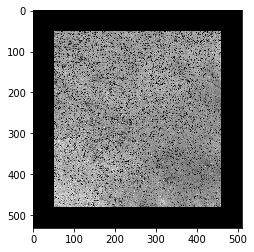

In [4]:
# Display
plt.imshow(ref_image, cmap='gray')

## Deform Ref Image

In [5]:
# Translate image
dx = 5.0
dy = 0.0
transx = np.array([[1.0, 0.0, dx],
                   [0.0, 1.0, dy]])
def_image = image_processing.im_warp(ref_image, transx)

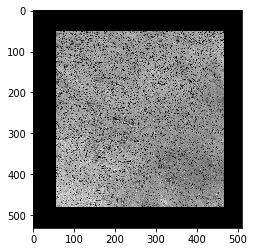

In [6]:
# Display
plt.imshow(def_image, cmap='gray')

## Manually Specify Region of Interest

In [7]:
# Format: [column index for start of X, column index for end of X, row index for start of Y, row index for end of Y]
subregion_indices = np.array([125, 375, 125, 375])

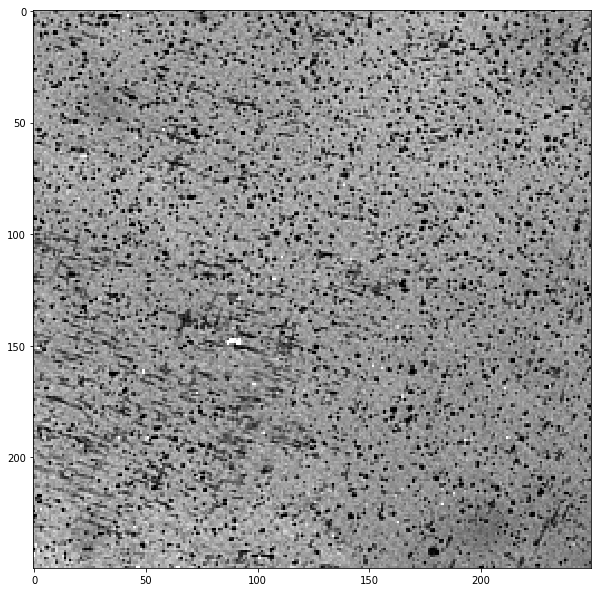

In [8]:
# Extract these regions from ref image and plot
ref_subimage = ref_image[subregion_indices[2]:subregion_indices[3], subregion_indices[0]:subregion_indices[1]]
fig, ax = plt.subplots(figsize=(10, 20))
ax.imshow(ref_subimage, cmap='gray')
plt.show()

## Setup reference mesh

In [9]:
# Control Points
rowmin = subregion_indices[-2:].min()
rowmax = subregion_indices[-2:].max()
colmin = subregion_indices[:2].min()
colmax = subregion_indices[:2].max()
x = np.linspace(colmin, colmax, 4)
y = np.linspace(rowmin, rowmax, 4)
coords = np.zeros((len(x) * len(y), 2))
k = 0
for i in range(0, len(x)):
    for j in range(0, len(y)):
        coords[k, :] = np.array([x[i], y[j]])
        k += 1

In [10]:
# Surface
ref_surf = bs.Surface()

ref_surf.degree_u = 3
ref_surf.degree_v = 3

num_ctrlpts = np.sqrt(len(coords)).astype('int')

ref_surf.set_ctrlpts(coords.tolist(), num_ctrlpts, num_ctrlpts)

ref_surf.knotvector_u = gutil.generate_knot_vector(ref_surf.degree_u, num_ctrlpts)
ref_surf.knotvector_v = gutil.generate_knot_vector(ref_surf.degree_v, num_ctrlpts)

ref_surf.delta = 0.01

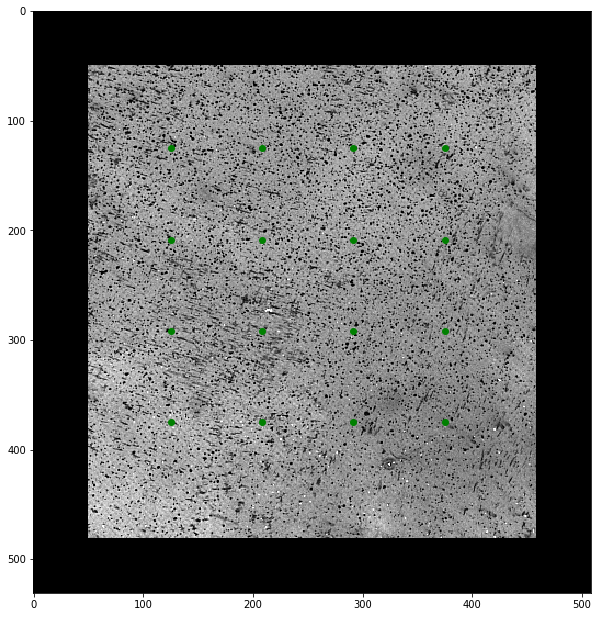

In [11]:
# Plot the mesh nodes on the original image
# Would be nice to be able to visualize full mesh
x = coords[:, 0]
y = coords[:, 1]
fig, ax = plt.subplots(figsize=(10, 20))
ax.imshow(ref_image, cmap='gray')
ax.plot(x, y, 'o', color='green')
plt.show()

## Pack necessary arguments into a tuple

In [12]:
arg_tup = (ref_image, def_image, ref_surf)

## Write minfun to pass to scipy optimize

In [13]:
def minfun_nm(disp_vec, *args):
    
    '''
    Minimizatin function for passing to scipy minimize using Nelder-Mead method
    
    Assembles solution vector and arguments, then passes to mesh_znssd to compute cost
    
    :param disp_vec: trial displacement vector. Shape is (1, 2*num_ctrltps) and is orderd
    [delta x0, delta y0, delta x1, delta y1, etc.]
    :type disp_vec: ndarray
    return: scalar value of mesh znssd at the trial displacement vector
    :rtype: float
    '''
       
    # Assemble displacement vector
    ctrlpt_disp = np.zeros((int(len(disp_vec)/2), 2))
    for i in range(0, len(disp_vec), 2):
        k = i // 2  # Modulo to keep the index from over running length of ctrlpt_disp
        ctrlpt_disp[k, :] = np.array([disp_vec[i], disp_vec[i + 1]])
        
    # Call znssd with defaults on all keyward params. This will make it a bit slower, but whatever for now
    znssd = analysis.mesh_znssd(*args, ctrlpt_disp)
    
    return znssd
    

## Wrap this minfun in scipy optimization library

In [14]:
# Compute rigid initial correlation with 2d correlation
rowmid = int(np.mean([rowmin, rowmax]))
colmid = int(np.mean([colmin, colmax]))

# Get subimage
subimage = np.copy(ref_image[subregion_indices[2]:subregion_indices[3], subregion_indices[0]:subregion_indices[1]])

# Normalize images
ref_subnorm = subimage - subimage.mean()
def_norm = def_image - def_image.mean()

# Correlate
corr = sig.correlate2d(def_norm, ref_subnorm, boundary='symm', mode='same')
midy, midx = np.unravel_index(np.argmax(corr), corr.shape)

initx = (midx + 1) - colmid
inity = (midy + 1) - rowmid

# Setup initial displacement vector
int_disp_vec = np.zeros(2*len(coords))
for i in range(0, len(int_disp_vec), 2):
    int_disp_vec[i] = initx
    int_disp_vec[i+1] = inity

# compute mesh znssd one time and exit if its low enough

residual = minfun_nm(int_disp_vec, *arg_tup)

if residual > 1e-6:
    print('Begin minimization')
    result = sciopt.minimize(minfun_nm, int_disp_vec, args=arg_tup, method='Nelder-Mead', options={'maxiter': 10, 'disp': True})

print('Actual Rigid X Displacement: {}'.format(dx))
print('Actual Rigid Y Displacement: {}'.format(dy))
print('Mesh Details: {} by {}'.format(num_ctrlpts, num_ctrlpts))
print('Initial Guess -  X Displacement: {}'.format(initx))
print('Initial Guess - Y Displacement: {}'.format(inity))

if residual > 1e-6:
    print('residual')
    print(result.fun)
    print('final control point displacements')
    print(result.x)
else:
    print('residual')
    print(residual)
    print('final control point displacement')
    print(int_disp_vec)

Actual Rigid X Displacement: 5.0
Actual Rigid Y Displacement: 0.0
Mesh Details: 4 by 4
Initial Guess -  X Displacement: 5
Initial Guess - Y Displacement: 0
residual
1.4405285221319367e-09
final control point displacement
[5. 0. 5. 0. 5. 0. 5. 0. 5. 0. 5. 0. 5. 0. 5. 0. 5. 0. 5. 0. 5. 0. 5. 0.
 5. 0. 5. 0. 5. 0. 5. 0.]


## Visualize results

In [15]:
# Create control point displacement vectors from minimization results
disp_cpts = np.column_stack((int_disp_vec[::2], int_disp_vec[1::2]))

In [16]:
# Set up new surface
disp_surf = bs.Surface()

disp_surf.degree_u = 3
disp_surf.degree_v = 3

num_ctrlpts = np.sqrt(len(disp_cpts)).astype('int')

disp_surf.set_ctrlpts(disp_cpts.tolist(), num_ctrlpts, num_ctrlpts)

disp_surf.knotvector_u = gutil.generate_knot_vector(disp_surf.degree_u, num_ctrlpts)
disp_surf.knotvector_v = gutil.generate_knot_vector(disp_surf.degree_v, num_ctrlpts)

disp_surf.delta = 0.01

In [17]:
# Fill x and y displacement arrays
U = np.zeros(ref_image.shape) * np.nan
V = np.zeros(ref_image.shape) * np.nan

for i in range(rowmin, rowmax):
    for j in range(colmin, colmax):
        u_val = (j - colmin) / (colmax - colmin)
        v_val = (i - rowmin) / (rowmax - rowmin)
        disp = disp_surf.surfpt(u_val, v_val)
        U[i, j] = disp[0]
        V[i, j] = disp[1]
        

Text(0.5, 1.0, 'Y Displacement (Pixels)')

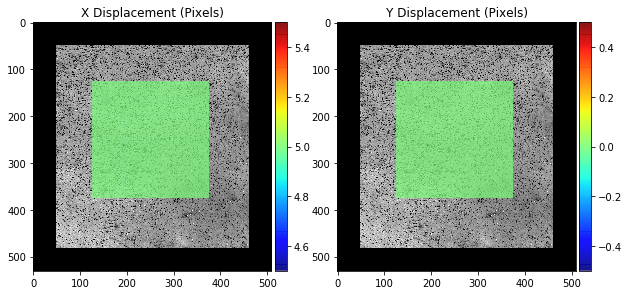

In [18]:
# Display
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 10))
im0 = ax0.imshow(ref_image, cmap='gray')
Uim = ax0.imshow(U, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax0)
cax0 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(Uim, cax=cax0)
Uim.set_clim(4.5, 5.5)
ax0.set_title('X Displacement (Pixels)')

im1 = ax1.imshow(ref_image, cmap='gray')
Vim = ax1.imshow(V, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(Vim, cax=cax1)
Vim.set_clim(-0.5, 0.5)
ax1.set_title('Y Displacement (Pixels)')